# ПРОЕКТ: Определение стоимости автомобилей

Я работаю в сервисе по продаже автомобилей с пробегом: «Не бит, не крашен», который разрабатывает приложение, чтобы привлечь новых клиентов. \
В моём распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Цель проекта**: построить модель, которая умеет определять рыночную стоимость автомобиля.
- Критерии, которые важны заказчику:
1. Качество предсказания;
2. Время обучения модели;
3. Время предсказания модели.

**Ход исследования:**

*Шаг 1* - Загрузка данных;\
*Шаг 2* - Предобработка данных;\
*Шаг 3* - Исследовательский анализ данных;\
*Шаг 4* - Подготовка выборок для обучения моделей;\
*Шаг 5* - Обучение нескольких моделей;\
*Шаг 6* - Анализ времени обучения, времени предсказания и качества моделей;\
*Шаг 7* - Выбор лучшей модели, проверка её качества на тестовой выборке.

Итоговый вывод.

## Шаг 1. Загрузка и подготовка данных

In [1]:
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
# импоритруем pandas для обработки, анализа и структурирования данных
import pandas as pd 

# импоритруем numpy для работы с данными
import numpy as np 

# так же импоритруем matplotlib.pyplot для будущего построения графиков
import matplotlib.pyplot as plt 

# так же импоритруем seaborn для построения графиков
import seaborn as sns 

# импоритруем phik для построения матрицы корреляций Фи
import phik 

# Импортируем функцию для разделения датасета на выборки
from sklearn.model_selection import train_test_split, GridSearchCV

# Импортируем классы для кодирования 
from sklearn.preprocessing import (
OneHotEncoder,
StandardScaler
)

# Подключаем метрику MSE.
from sklearn.metrics import mean_squared_error as mse 

# подключаем модели для прогнозирования
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# Отключаем некритичные предупреждения:
import warnings
warnings.filterwarnings("ignore")
# Настройки отображения таблиц
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

### 1.1 Загрузим данные из csv-файла в датафреймы c помощью библиотеки pandas

In [3]:
try: # открываем наш файл с данными в среде JupiterHUB:
    data_auto = pd.read_csv('/datasets/autos.csv') # технические характеристики, комплектации и цены автомобилей.
        
except: # либо берем данные на ПК для локальной версии Jupiter:
    data_auto = pd.read_csv('C://Users//Voova//datasets//autos.csv') 

Описание данных:\
**Признаки**
- **DateCrawled** — дата скачивания анкеты из базы;
- **VehicleType** — тип автомобильного кузова;
- **RegistrationYear** — год регистрации автомобиля;
- **Gearbox** — тип коробки передач;
- **Power** — мощность (л. с.);
- **Model** — модель автомобиля;
- **Kilometer** — пробег (км);
- **RegistrationMonth** — месяц регистрации автомобиля;
- **FuelType** — тип топлива;
- **Brand** — марка автомобиля;
- **Repaired** — была машина в ремонте или нет;
- **DateCreated** — дата создания анкеты;
- **NumberOfPictures** — количество фотографий автомобиля;
- **PostalCode** — почтовый индекс владельца анкеты (пользователя);
- **LastSeen** — дата последней активности пользователя.

**Целевой признак**
- **Price** — цена (евро).

### 1.2 Изучим общую информацию о датафрейме. Выведим первые строки набора данных.

In [4]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Перед нами датафрейм на **16** колонок и **354 369** строк. Встречаются пропущенные значения. \
Посмотрим первые 5 строчек таблицы:

In [5]:
data_auto.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные в таблице соответствуют описанию, необходимо преобразовать типы данных столбцов *DateCrawled, DateCreated* и *LastSeen* к формату даты. \
А так же привести названия столбцов к общепринятым нормам. 

### Вывод:
В нашем распоряжении датафрейм data_auto:
- **16** колонок и **354 369** строк.

Для корректного исследования необходимо предобработать данные, а именно:
- Удалить столбцы, которые не несут ценности для построения модели;
- Привести названия столбцов в привычный вид;
- Преобразовать типы данных;
- Обработать пропущенные значения,
- Проверить датафрейм на явные/неявные дубликаты.

## Шаг 2. Предобработка и исследовательский анализ данных: 

### 2.1 Удаление неинформативных столбцов 

Согласно требованиям заказчика, модель должна прогнозировать цену на основании технических характеристик и  комплектации. \
Выберим столбцы, которые имеют наименьшую ценность, как признаки, при прогнозировании модели: 
- **DateCrawled** — дата скачивания анкеты из базы - удалю в конце, после проверки года регистрации;
- **RegistrationMonth** — месяц регистрации автомобиля;
- **NumberOfPictures** — количество фотографий автомобиля;
- **PostalCode** — почтовый индекс владельца анкеты (пользователя);
- **DateCreated** — дата создания анкеты;
- **LastSeen** — дата последней активности пользователя.

In [6]:
data_auto = data_auto.drop(['RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen'], axis = 1)

In [7]:
data_auto.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### 2.2 Редактирование названий столбцов

In [8]:
data_auto.columns = data_auto.columns.str.lower()

In [9]:
data_auto.rename(columns = {'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 'fueltype': 'fuel_type',}, inplace = True)

In [10]:
data_auto.head(5)

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### 2.3 Преобразование типов данных

Отмечу, что столбцы, которые я собирался приводить к формату даты - нам больше не интересны и удалены.\
Из оставшихся с нами столбцов - преобразовать можем, разве что `repaired` в `bool`, но сначала нужно заполнить пропуски, чтобы Nan не преобразовались автоматически в False, да и вообще на этапе кодирования этот категориальный признак и так будет работатать. Оставим как есть. 

### 2.4 Обработка пропущенных значений

Посмотрим количество пропущенных значений в датафрейме: 

In [11]:
miss_nan = pd.DataFrame({
    'Пропущено': data_auto.isna().sum(),
    '% пропусков': data_auto.isna().mean() * 100
}).sort_values(by = '% пропусков', ascending = False)
miss_nan

,Пропущено,% пропусков
repaired,71154,20.079070
vehicle_type,37490,10.579368
fuel_type,32895,9.282697
gearbox,19833,5.596709
model,19705,5.560588
datecrawled,0,0.000000
price,0,0.000000
registration_year,0,0.000000
power,0,0.000000
kilometer,0,0.000000


2.4.1 Работаем с `repaired`.

Как видно выше - **20 %** пользователей предпочти скрыть информацию о факте повреждения авто, но мы не можем знать этого наверняка, поэтому предлагаю заполнить пропуски в repaired рандомно в соотношении *50* на *50*. \
На мой взгляд - наличие автомобиля в ремонте будет оказывать существенное влияние на цену, поэтому хотелось бы сделать заполнение пропусков максимально *непредвзято*.  

In [12]:
np.random.seed(42) # зафиксируем константу для функции рандома

In [13]:
data_auto['repaired'] = data_auto['repaired'].fillna('unknown')
data_auto.head(5)

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


2.4.2 Работаем с `vehicle_type`.

Посмотрим какие вообще типы кузовов у нас присутствуют:

In [14]:
data_auto['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Чтобы не выдумывать лишнего - предлагаю пропуски в данных приравнять к категории `other`.

In [15]:
data_auto['vehicle_type'] = data_auto['vehicle_type'].fillna('other')

2.4.3 Работаем с `fuel_type`.

Посмотрим разновидности топлива наших автомобилей:

In [16]:
data_auto['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Предлагаю заполнить пропуски самым частовстречающимся значением. 

In [17]:
data_auto['fuel_type'] = data_auto.groupby('brand')['fuel_type'].transform(
            lambda x: x.fillna((x.mode()[0] if not x.mode().empty else 'other')))
data_auto.head(5)

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


2.4.4 Работаем с `gearbox`.

Посмотрим, какая трансмиссия используется в предоставленных авто:

In [18]:
data_auto['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Предлагаю заполнить так же рандомно с соотношением 50/50:

In [19]:
data_auto['gearbox'] = data_auto['gearbox'].fillna('unknown')
data_auto.head(5)

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


2.4.5 Работаем с `model`.

Модель автомобиля должна очень сильно коррелировать с его стоимостью, не хотелось бы вмешиваться в имеющиеся данные (в плане того, что мы можем автомобилю с маленькой ценой присвоить "дорогую" марку и наоборот), а так как пропуски составляют 5,56 % от всего датасета - предлагаю удалить эти данные. 

In [20]:
data_auto['model'] = data_auto['model'].fillna('other')
data_auto.head(5)

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Еще раз взглянем на количество пропусков в датасете: 

In [21]:
miss_before = pd.DataFrame({
    'Пропущено': data_auto.isna().sum(),
    '% пропусков': data_auto.isna().mean() * 100
}).sort_values(by = '% пропусков', ascending = False)
miss_before

,Пропущено,% пропусков
datecrawled,0,0.0
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gearbox,0,0.0
power,0,0.0
model,0,0.0
kilometer,0,0.0
fuel_type,0,0.0
brand,0,0.0


Отлично, от пропусков избавились !

### 2.5 Проверка на явные/неявные дубликаты: 

In [22]:
data_auto.duplicated().sum() # выведим сумму явных дубликатов:

25

In [23]:
# удаляем полные дубликаты
data_auto.drop_duplicates(inplace = True)

Проверим датасет на неявные дубликаты : 

In [24]:
# В предыдущем пункте с удалением Nan мы уже смотрели уникальные значения столбцов, осталось проверить только `brand`
data_auto['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Неявные дубликаты не обнаружены. 

In [25]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354344 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354344 non-null  object
 1   price              354344 non-null  int64 
 2   vehicle_type       354344 non-null  object
 3   registration_year  354344 non-null  int64 
 4   gearbox            354344 non-null  object
 5   power              354344 non-null  int64 
 6   model              354344 non-null  object
 7   kilometer          354344 non-null  int64 
 8   fuel_type          354344 non-null  object
 9   brand              354344 non-null  object
 10  repaired           354344 non-null  object
dtypes: int64(4), object(7)
memory usage: 32.4+ MB


### Вывод: 
На этапе предобработки данных мы:
- Удалили неинформативные столбцы;
- Привели названия столбцов в общепринятый вид;
- Обработали пропущенные значения - пропуски заполнены по смыслу медианными значениями либо заглушками;
- Проверили датафрейм на явные/неявные дубликаты, удалено *47321* явных дубликатов.

В итоговом виде у нас получилось **10** колонок на **354 344** ненулевых строк: \
Изучим содержимое в исследовательском анализе данных: 

## Шаг 3. Исследовательский анализ данных:

1. Вызовем описательную функцию и построим гистограмму для *`price`*:

In [26]:
data_auto['price'].describe()

count    354344.000000
mean       4416.561477
std        4514.167328
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Замечу, что минимальная цена равняется нулю, то есть имеются автомобили с некорректно заполненной ценой, посмотрим сколько таких объявлений:

In [27]:
data_auto.query('price == 0')

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,2016-03-26 22:06:17,0,other,1990,unknown,0,corsa,150000,petrol,opel,unknown
111,2016-03-19 18:40:12,0,other,2017,manual,0,golf,5000,petrol,volkswagen,unknown
115,2016-03-20 18:53:27,0,small,1999,unknown,0,other,5000,petrol,volkswagen,unknown
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,other,2000,manual,65,corsa,150000,petrol,opel,yes
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,petrol,ford,unknown
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,petrol,suzuki,unknown
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


6990 строк с неопознанной ценой - предлагаю избавиться от этих автомобилей:

In [28]:
data_auto = data_auto.query('price != 0')

Посмотрим, сколько у нас автомобилей вообще продаются по цене до 100 евро:

In [29]:
data_auto.query('price <= 100')

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
59,2016-03-29 15:48:15,1,suv,1994,manual,286,other,150000,petrol,sonstige_autos,unknown
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,petrol,audi,no
408,2016-03-29 18:51:58,1,other,2000,unknown,75,golf,90000,petrol,volkswagen,unknown
552,2016-03-21 10:52:52,50,other,1985,unknown,0,other,150000,petrol,trabant,unknown
...,...,...,...,...,...,...,...,...,...,...,...
353682,2016-03-07 13:53:17,1,bus,1999,manual,0,espace,150000,petrol,renault,unknown
353727,2016-03-20 17:56:59,1,other,2000,unknown,0,other,150000,petrol,bmw,unknown
354018,2016-03-14 20:53:59,100,small,1996,manual,0,polo,150000,petrol,volkswagen,unknown
354117,2016-03-28 14:38:14,1,wagon,1993,auto,217,5er,150000,petrol,bmw,unknown


Как видно выше - в продаже имеются **2746** позиций по цене от *1* евро до *100*, на мой взгляд - эти данные `аномальные`, либо это атракцион невиданной щедрости, что маловероятно, либо это опечатка при подаче объявления. \
Предлагаю установить минимальный порог цены хотябы в 50 евро. 

In [30]:
data_auto = data_auto.query('price >= 50')

Построим гистограмму распределения автомобилей по цене: 

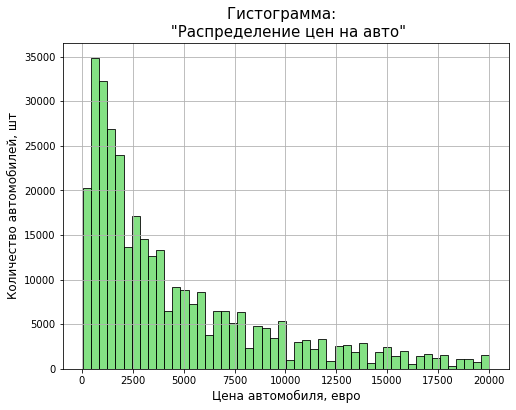

In [31]:
plt.figure(figsize = (8, 6))
sns.histplot(data = data_auto, bins = 50,  
             x = 'price',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Распределение цен на авто"', size = 15)
plt.xlabel('Цена автомобиля, евро', size = 12)
plt.ylabel('Количество автомобилей, шт', size = 12)
plt.grid(True)
plt.show()

Тип распределения похож на нормальное со сдвигом влево, средняя цена продажи авто составляет порядка 4750 евро. 

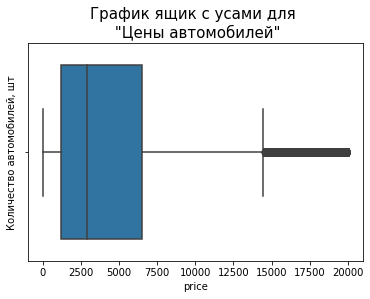

In [32]:
sns.boxplot(data_auto['price'])
plt.title('График ящик с усами для \n "Цены автомобилей"', size = 15)
plt.ylabel('Количество автомобилей, шт', size = 10)
plt.show()

Как видно из боксплота - автомобили с ценой выше 15 000 евро, считаются выбросами. Выбросы будут сказываться на моделировании, однако избавляться мы от них не будем, так как они вполне могут быть обоснованы наличием премиальных автомобилей по высокой цене. 

2. Построим круговую диаграмму для *`vehicle_type`*	:

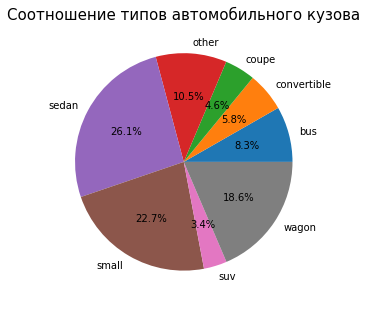

In [33]:
(
    data_auto
    .groupby('vehicle_type')['vehicle_type']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct = '%1.1f%%')
)
plt.xticks(rotation=45)
plt.title('Соотношение типов автомобильного кузова', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Наибольшую долю среди продающихся авто занимают седаны, в то время как меньше всего продают внедорожники. 

3. Вызовем описательную функцию и построим гистограмму для *`registration_year`*:

In [34]:
data_auto['registration_year'].describe()

count    341921.000000
mean       2004.079849
std          77.073335
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

В данном столбце у нас так же имеются аномалии, **1000** год и **9999** год - явно являются результатами опечаток или ошибок при переносе данных. 

In [35]:
data_auto.query('registration_year == 9999')

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
17271,2016-03-23 16:43:29,700,other,9999,unknown,0,other,10000,petrol,opel,unknown
28390,2016-04-05 08:57:08,799,other,9999,unknown,0,3er,10000,petrol,bmw,unknown
28965,2016-04-04 22:54:47,18000,other,9999,unknown,0,a_klasse,10000,petrol,mercedes_benz,unknown
29426,2016-03-23 21:52:25,7999,other,9999,unknown,0,kaefer,10000,petrol,volkswagen,unknown
50141,2016-03-14 22:54:43,50,other,9999,unknown,0,911,10000,petrol,porsche,unknown
62395,2016-03-16 23:54:17,55,other,9999,unknown,0,other,10000,petrol,volkswagen,unknown
128677,2016-03-14 14:51:56,1550,other,9999,unknown,95,other,10000,petrol,volkswagen,unknown
149151,2016-04-02 18:57:33,400,other,9999,unknown,0,other,10000,petrol,sonstige_autos,unknown
167937,2016-03-23 13:49:51,1000,other,9999,unknown,0,other,10000,petrol,mazda,unknown
200525,2016-03-22 15:56:52,850,other,9999,unknown,0,other,10000,petrol,mazda,unknown


In [36]:
data_auto.query('registration_year == 1000')

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
16062,2016-03-29 23:42:16,190,other,1000,unknown,0,mondeo,5000,petrol,ford,unknown
53577,2016-03-20 11:44:28,330,other,1000,unknown,0,polo,5000,petrol,volkswagen,unknown
55605,2016-03-10 19:50:17,500,other,1000,unknown,0,other,5000,petrol,citroen,yes
60017,2016-03-10 12:38:01,80,other,1000,unknown,0,other,5000,petrol,volkswagen,unknown
66198,2016-03-08 14:50:20,1300,other,1000,auto,0,other,5000,petrol,sonstige_autos,unknown
...,...,...,...,...,...,...,...,...,...,...,...
243656,2016-03-29 16:52:03,2500,other,1000,unknown,34,other,5000,petrol,sonstige_autos,unknown
244092,2016-03-26 19:52:56,2000,other,1000,unknown,0,other,5000,petrol,sonstige_autos,unknown
256532,2016-03-05 17:44:47,12500,other,1000,unknown,200,golf,5000,petrol,volkswagen,unknown
275472,2016-04-05 11:39:14,530,other,1000,unknown,0,300c,5000,petrol,chrysler,unknown


Минимумы и максимумы посмотрели, аномалий не много - нужно взглянуть, какие аномалии ещё присутвуют: 

In [37]:
data_auto['registration_year'].value_counts()

2000    22817
1999    21894
2005    21401
2006    19650
2001    19588
        ...  
1949        1
2222        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 139, dtype: int64

In [38]:
data_auto.query('registration_year == 1910')

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,2016-03-11 21:39:15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
6977,2016-03-24 08:37:22,135,other,1910,unknown,0,other,5000,petrol,opel,unknown
10183,2016-03-27 13:59:08,1250,other,1910,unknown,0,other,5000,petrol,audi,unknown
23750,2016-03-16 19:58:34,3900,wagon,1910,manual,90,passat,150000,petrol,volkswagen,unknown
24458,2016-03-29 19:50:03,50,small,1910,manual,0,other,5000,petrol,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...,...
294091,2016-03-15 17:43:20,75,other,1910,unknown,0,other,100000,petrol,sonstige_autos,unknown
304262,2016-03-26 19:55:31,150,other,1910,manual,0,ka,5000,petrol,ford,yes
321995,2016-03-10 15:58:12,180,other,1910,manual,0,mondeo,150000,petrol,ford,yes
334901,2016-03-29 03:36:18,1300,other,1910,unknown,0,other,5000,petrol,audi,unknown


Предлагаю отсечь лишнее - ограничимся минимально **1930** годом, т.к. такие автомобильные марки как Ford, BMW, Mercedes-Benz как раз начинали свой путь в то время, предположим что это супер коллекционные экземпляры. Как видно выше - объявления за *1910* год это явные ошибки в данных, так как цены на коллекционные аппараты должны быть высокими, а здесь у нас авто по цене вековой пыли. \
По верхней границе берем **2019** год. 

In [39]:
data_auto = data_auto.query('registration_year >= 1930 and registration_year <= 2019')

In [40]:
data_auto['datecrawled'] = pd.to_datetime(data_auto['datecrawled'])
data_auto['datecrawled'] = pd.DatetimeIndex(data_auto['datecrawled']).year

In [41]:
data_auto.query('registration_year > datecrawled')

,datecrawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
22,2016,2900,other,2018,manual,90,meriva,150000,petrol,opel,no
26,2016,5555,other,2017,manual,125,c4,125000,petrol,citroen,no
48,2016,7750,other,2017,manual,80,golf,100000,petrol,volkswagen,unknown
51,2016,2000,other,2017,manual,90,punto,150000,gasoline,fiat,yes
57,2016,2399,other,2018,manual,64,other,125000,petrol,seat,no
...,...,...,...,...,...,...,...,...,...,...,...
354112,2016,3600,other,2017,manual,86,transit,150000,gasoline,ford,unknown
354140,2016,1000,other,2017,manual,101,a4,150000,petrol,audi,unknown
354203,2016,2140,other,2018,manual,80,fiesta,150000,petrol,ford,no
354253,2016,1250,other,2018,unknown,0,corsa,150000,petrol,opel,unknown


Действтельно, обнаружены объявления в которых дата выгрузки объявления раньше, чем дата регистрации авто - следовательно ошибка в дате регистрации.\
Не представляю на что мы можем поправить эти даты, поэтому предлагаю избавиться от этих столбцов. 

In [42]:
data_auto = data_auto.query('registration_year <= datecrawled')

Столбец `datecrawled` свою функцию выполнил, два столбца с датой нам ни к чему - тем более, что нужно сделать проверку на дубликаты, удаляем этот столбец. 

In [43]:
data_auto = data_auto.drop(['datecrawled'], axis = 1)

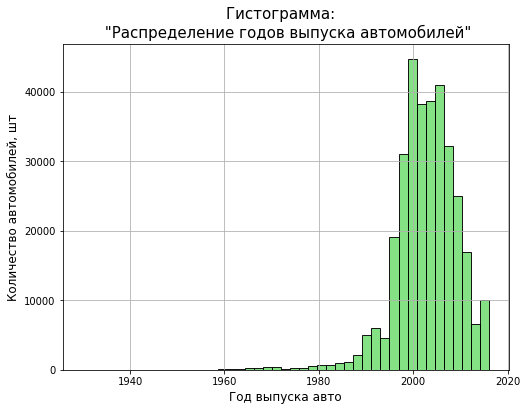

In [44]:
plt.figure(figsize = (8, 6))
sns.histplot(data = data_auto, bins = 45,  
             x = 'registration_year',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Распределение годов выпуска автомобилей"', size = 15)
plt.xlabel('Год выпуска авто', size = 12)
plt.ylabel('Количество автомобилей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение годов выпуска соответсвует нормальному, хвост в левой части мы умышленно оставили из за коллекционных моделей, хотя можно было бы сделать нижнюю границу по 1980 году, но не хочется терять данные.

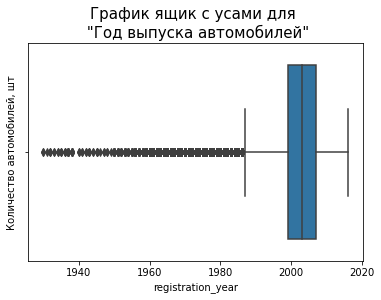

In [45]:
sns.boxplot(data_auto['registration_year'])
plt.title('График ящик с усами для \n "Год выпуска автомобилей"', size = 15)
plt.ylabel('Количество автомобилей, шт', size = 10)
plt.show()

Все авто, старше 1985 года являются выбросами, если они будут сильно мешать качеству модели - произведем корректировку по минимальному году выпуска. 

4. Построим круговую диаграмму для *`gearbox`*:

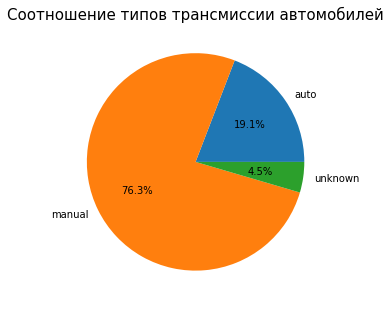

In [46]:
(
    data_auto
    .groupby('gearbox')['gearbox']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct = '%1.1f%%')
)
plt.title('Соотношение типов трансмиссии автомобилей', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Наиболее распространенной является механическая трансмиссия, с долей порядка 80%. 

5. Вызовем описательную функцию и построим гистограмму для *`power`*:

In [47]:
data_auto['power'].describe()

count    328119.000000
mean        112.145298
std         185.112193
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

В данном столбце у нас так же имеются аномалии, нулевая мощность и 20 000 л.с. - явно являются результатами опечаток или ошибок при переносе данных. 

In [48]:
data_auto.query('power == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,other,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,petrol,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354336,3299,other,2005,auto,0,outlander,150000,petrol,mitsubishi,unknown
354338,180,other,1995,unknown,0,other,125000,petrol,opel,unknown
354346,2600,other,2005,auto,0,c_klasse,150000,petrol,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


Не хотелось бы терять 32029 строки и за нулевой мощности, постараемся заменить нули медианной мощностью, соответствующей своей модели авто: 

In [49]:
for t in data_auto['model'].unique():
    # находим медиану соответствующей модели авто
    median_power = data_auto.loc[
        (data_auto['model'] == t) & 
        (data_auto['power'] > 0),  # исключаем нули 
        'power'
    ].median()
    
    # заменяем нулевые значения на медиану
    data_auto.loc[
        (data_auto['model'] == t) & 
        (data_auto['power'] == 0),  # выбираем только нули
        'power'
    ] = median_power

При округлении полученных значений мощности у меня выскакивала ошибка по наличию Nan или Inf и невозможности округлиться и преобразоваться в int, поэтому проведем проверку на аномалии:

In [50]:
# Проверяем на наличие нестандартных значений
print("NaN values:", data_auto['power'].isna().sum())
print("Inf values:", np.isinf(data_auto['power']).sum())

NaN values: 1
Inf values: 0


In [51]:
data_auto[data_auto['power'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
234296,3800,wagon,1978,manual,NaN,serie_1,30000,gasoline,land_rover,unknown


И удалим один пропуск в данных, тем самым из 32029 строк с нулевой мощностью - мы удалим только одну строку. 

In [52]:
data_auto = data_auto.dropna(subset = ['power'])

In [53]:
data_auto['power'] = data_auto['power'].round().astype('int64')

Так же ограничим мощность порогом в 500 л.с. - так как мощность выше указанной на гражданский автомобилях почти не встречается.\
нижний порог ограничим в 30 л.с. так как эта мощность похожа на минимальную, встречающуюся у авто. 

In [54]:
data_auto = data_auto.query('power >= 30 and power <= 500')

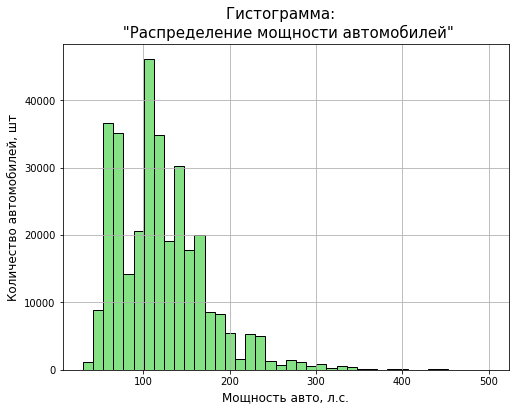

In [55]:
plt.figure(figsize = (8, 6))
sns.histplot(data = data_auto, bins = 40,  
             x = 'power',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Распределение мощности автомобилей"', size = 15)
plt.xlabel('Мощность авто, л.с.', size = 12)
plt.ylabel('Количество автомобилей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение похоже на нормальный вид со смещением вправо, средняя мощность автомобилей составляет порядка 120 лошадиныхх сил. 

6. Построим диаграмму для *`model`*:

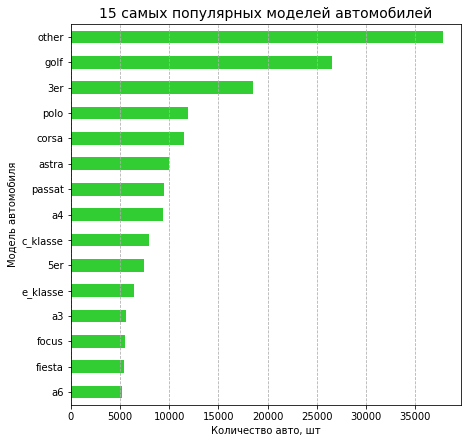

In [56]:
plt.figure(figsize = (7, 7))
data_auto['model'].value_counts().sort_values().tail(15).plot(kind = 'barh', color = 'limegreen')
plt.title('15 самых популярных моделей автомобилей', size = 14)
plt.xlabel('Количество авто, шт')
plt.ylabel('Модель автомобиля')
plt.grid(axis = 'x', linestyle = '--')
plt.show()

На диаграмме выше видно, что в топ-3 по моделям входят VV Golf, другие и BMW 3er. 

7. Вызовем описательную функцию и построим гистограмму для *`kilometer`*:

In [57]:
data_auto['kilometer'].describe()

count    326792.000000
mean     128539.086024
std       37084.862089
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

На мой взгляд, значение пробега находится в адекватных рамках - хотя максимальное значение в 150 000 км может быть обусловлено ограничением сервиса, так как пробег 20-30 летних авто заходит далеко за 150 000 км, в реальной ситуации я бы проконсультировался с собственниками или старшими коллегами. 

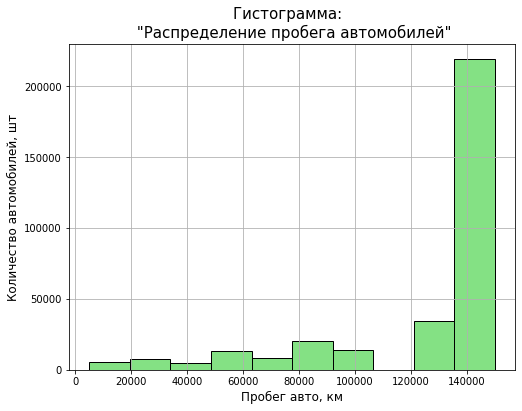

In [58]:
plt.figure(figsize = (8, 6))
sns.histplot(data = data_auto, bins = 10,  
             x = 'kilometer',
             color = 'limegreen', 
             alpha = 0.6)
plt.title('Гистограмма:  \n "Распределение пробега автомобилей"', size = 15)
plt.xlabel('Пробег авто, км', size = 12)
plt.ylabel('Количество автомобилей, шт', size = 12)
plt.grid(True)
plt.show()

Явно у большинства автомобилей пробег так и просится в большую сторону от 150 000 км, а так наше распределение очень перекошено вправо. 

8. Построим диаграмму для *`fuel_type`*:

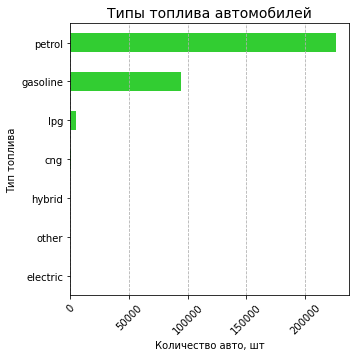

In [59]:
plt.figure(figsize = (5, 5))
data_auto['fuel_type'].value_counts().sort_values().plot(kind = 'barh', color = 'limegreen')
plt.xticks(rotation = 45)
plt.title('Типы топлива автомобилей', size = 14)
plt.xlabel('Количество авто, шт')
plt.ylabel('Тип топлива')
plt.grid(axis = 'x', linestyle = '--')
plt.show()

По сути Gasoline — американский термин, petrol — британский, обозначающие **бензин**. Поэтому можно было бы объединить их в одну категорию, хотя скорее всего может имелся ввиду дизель вместо одной популярной категории, т.к. на практике всегда в топе идет бензин и дизель. 

9. Построим диаграмму для *`brand`*:

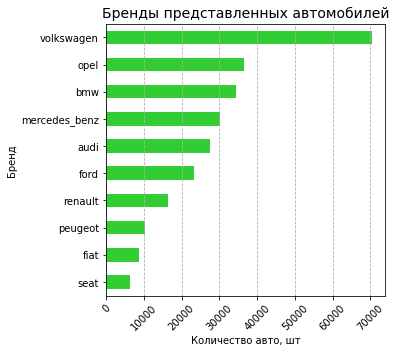

In [60]:
plt.figure(figsize = (5, 5))
data_auto['brand'].value_counts().sort_values().tail(10).plot(kind = 'barh', color = 'limegreen')
plt.xticks(rotation = 45)
plt.title('Бренды представленных автомобилей', size = 14)
plt.xlabel('Количество авто, шт')
plt.ylabel('Бренд')
plt.grid(axis = 'x', linestyle = '--')
plt.show()

В топ-3 бренда входят Volkswagen, Opel и BMW.

10. Построим круговую диаграмму для *`repaired`*:

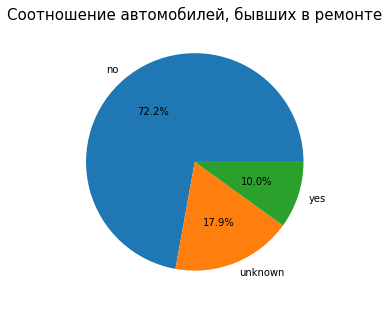

In [61]:
(
    data_auto
    .groupby('repaired')['repaired']
    .count()
    .plot(kind = 'pie', figsize = (5, 5), autopct = '%1.1f%%')
)
plt.title('Соотношение автомобилей, бывших в ремонте', size = 15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Большинство авто в нашем перечне - без ДТП.

In [62]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326792 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              326792 non-null  int64 
 1   vehicle_type       326792 non-null  object
 2   registration_year  326792 non-null  int64 
 3   gearbox            326792 non-null  object
 4   power              326792 non-null  int64 
 5   model              326792 non-null  object
 6   kilometer          326792 non-null  int64 
 7   fuel_type          326792 non-null  object
 8   brand              326792 non-null  object
 9   repaired           326792 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.4+ MB


In [63]:
data_auto = data_auto.reset_index(drop = True) # еще можем сбросить все индексы после очистки данных

Посмотрим, как коррелируют наши признаки: 

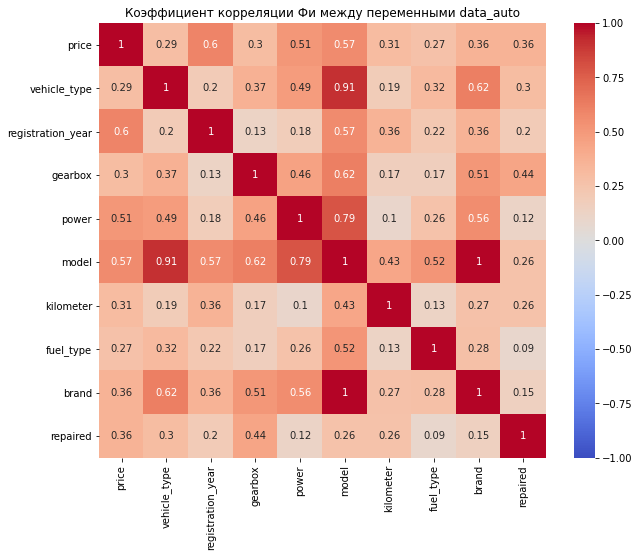

In [64]:
# Вычисляем матрицу корелляций Фи
phi_corr = data_auto.phik_matrix(interval_cols = ['price', 'registration_year',
                                                      'power', 'kilometer']).round(2)

# Строим ХитМэп корреляций Фи
plt.figure(figsize = (10, 8))
sns.heatmap(phi_corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title("Коэффициент корреляции Фи между переменными data_auto")
plt.show()

В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность целевого признака отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`price`**:
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `registration_year` **(0,6)**, `model` **(0,57)**, `power` **(0,51)** показывает нам, что все эти параметры умеренно влияют на цену автомобиля. 

### Вывод: 
На этапе исследовательского анализа мы выяснили, что:
- Средняя цена автомобилей в продаже - порядка **4750 евро**,
- Самый популярный тип кузова авто - **седан**,
- Средний год выпуска авто - **2003**,
- Наиболее распространенной является **механическая трансмиссия**, с долей порядка 80%,
- В среднем, в продаже авто с мощностью **120 л.с.**,
- Топ-3 по моделям в продаже составляют **VV Golf**, *категория другие* и BMW 3er.
- Средний пробег авто составляет **127 000** километров,
- Самым часто распространенным типом топлива является **бензин**. 
- В топ-3 бренда входят **Volkswagen**, Opel и BMW,
- Порядка 80 % автомобилей *не были в ДТП*.
- А так же после очистки от аномалий мы немного сократили наш датасет до **281 537** строк.
- Обнаружена умеренная положительная корреляция с `registration_year` **(0,6)**, `model` **(0,57)**, `power` **(0,51)**, что легко связывается с реальным миром - ведь возраст, модель и мощность первостепенно влияют на стоимость автомобиля. 

In [65]:
# КОД РЕВЬЮЕРА

data_auto.duplicated().sum()

45255

In [66]:
# удаляем полные дубликаты
data_auto.drop_duplicates(inplace = True)
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281537 entries, 0 to 326791
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              281537 non-null  int64 
 1   vehicle_type       281537 non-null  object
 2   registration_year  281537 non-null  int64 
 3   gearbox            281537 non-null  object
 4   power              281537 non-null  int64 
 5   model              281537 non-null  object
 6   kilometer          281537 non-null  int64 
 7   fuel_type          281537 non-null  object
 8   brand              281537 non-null  object
 9   repaired           281537 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


## Шаг 4. Подготовка выборок для обучения моделей

Подготовим признаки и разделим данные на обучающую и тестовую выборки:

In [67]:
# используемые константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [68]:
data_cat = data_auto.copy()
data_cat['registration_year'] = data_cat['registration_year'].astype(str)

In [69]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data_cat.drop(['price'], axis = 1),
                                                    data_cat['price'], 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE
                                                   )

In [70]:
print(f'Размер обучающей выборки:{y_train_cat.shape[0]}')
print("="*50)
print(f'Размер тестовой выборки:{y_test_cat.shape[0]}')

Размер обучающей выборки:211152
Размер тестовой выборки:70385


In [71]:
data_light = data_auto.copy()
data_light = data_light.astype(
    {"vehicle_type":'category', 
     "registration_year":'category',
     "gearbox":'category', 
     "model":'category',
     "fuel_type":'category',
     "brand":'category',
     'repaired':'category',}
)


In [72]:
X_train_light, X_test_light, y_train_light, y_test_light = train_test_split(data_light.drop(['price'], axis = 1),
                                                    data_light['price'], 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE
                                                   )

In [73]:
print(f'Размер обучающей выборки:{y_train_light.shape[0]}')
print("="*50)
print(f'Размер тестовой выборки:{y_test_light.shape[0]}')

Размер обучающей выборки:211152
Размер тестовой выборки:70385


In [74]:
data_ohe = data_auto.copy()

X = data_ohe.drop(['price'], axis = 1)
y = data_ohe['price']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE
                                                   )

In [75]:
# список категориальных признаков из датасета
cats_features = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
# список количественных признаков из датасета
colich_col_names = ['registration_year', 'power', 'kilometer']

In [76]:
# создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

In [77]:
# обучаем и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[colich_col_names])

In [78]:
# преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[colich_col_names])

In [79]:
# выберим класс OneHotEncoder() для кодирования 
# зададим параметру sparse_output значение False
try: 
    encoder  = OneHotEncoder(handle_unknown = 'ignore', sparse = False )
except:
    encoder  = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False )

In [80]:
# обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cats_features])

In [81]:
# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cats_features])

In [82]:
# сохраним в переменной encoder_col_names названия новых столбцов 
try:
    encoder_col_names =  encoder.get_feature_names()
except:
     encoder_col_names =  encoder.get_feature_names_out()

In [83]:
# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

# для данных OHE названия столбцов укажим из переменной encoder_col_names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = colich_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = colich_col_names)

In [84]:
# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
X_train = pd.concat([X_train_ohe, X_train_scaled], axis = 1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis = 1)

In [85]:
del data_light, data_ohe, data_cat, data_auto

## Шаг 5. Обучение моделей

### 5.1 CatBoost

In [86]:
model = CatBoostRegressor()
params = {
    'n_estimators' : [40, 90],
    'random_state' : [RANDOM_STATE],
    'max_depth' : [2, 6, 9],
    'verbose':[10]
}


grid_cv = GridSearchCV(
    estimator = model, 
    param_grid = params, 
    cv = 3, 
    n_jobs = -1, 
    scoring = 'neg_mean_squared_error'
)

In [87]:
%%time

grid_cv.fit(X_train_cat, y_train_cat, cat_features = cats_features)
cat_best_params = grid_cv.best_params_
print('Лучшие гиперпараметры: ', grid_cv.best_params_)
print(f'RMSE на тренировочной выборке: {round((-grid_cv.best_score_) ** 0.5, 3)}\n')

Learning rate set to 0.5
0:	learn: 3564.0356440	total: 97.9ms	remaining: 3.82s
10:	learn: 2288.4663092	total: 385ms	remaining: 1.01s
20:	learn: 2128.6739789	total: 641ms	remaining: 580ms
30:	learn: 2065.3749019	total: 896ms	remaining: 260ms
39:	learn: 2033.9375387	total: 1.12s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3567.4773868	total: 41.3ms	remaining: 1.61s
10:	learn: 2275.7286279	total: 323ms	remaining: 852ms
20:	learn: 2131.2359895	total: 582ms	remaining: 527ms
30:	learn: 2056.0653934	total: 839ms	remaining: 244ms
39:	learn: 2022.1191315	total: 1.08s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3568.8358400	total: 41.9ms	remaining: 1.63s
10:	learn: 2280.0965428	total: 322ms	remaining: 848ms
20:	learn: 2146.8187930	total: 579ms	remaining: 524ms
30:	learn: 2071.2246208	total: 830ms	remaining: 241ms
39:	learn: 2037.6978243	total: 1.06s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3564.0356440	total: 40.7ms	remaining: 3.62s
10:	learn: 2288.4663092	total: 321ms	remai

Лучшие гиперпараметры:  {'max_depth': 9, 'n_estimators': 90, 'random_state': 42, 'verbose': 10}
RMSE на тренировочной выборке: 1697.989

CPU times: user 1min 20s, sys: 2.42 s, total: 1min 23s
Wall time: 1min 38s


Значение метрики RMSE удовлетворяет условию задачи, т.к. меньше 2500 евро. 

### 5.2 LightGBM

In [88]:
%%time

model = LGBMRegressor()
params = {
    'metric': ['l2'],
    'boosting_type' : ['gbdt'],
    'n_estimators' : [25, 75],
    'max_depth' : [4, 6, 9],
    'random_state' : [RANDOM_STATE],
    'force_col_wise': [True],
    'num_leaves' : [64],
}
grid_cv = GridSearchCV(
    estimator = model,
    param_grid = params,
    cv = 3, 
    n_jobs = -1, 
    scoring = 'neg_mean_squared_error'
)

CPU times: user 239 µs, sys: 11 µs, total: 250 µs
Wall time: 255 µs


In [89]:
%%time

grid_cv.fit(X_train_light, y_train_light)
gbm_best_params = grid_cv.best_params_
print('Лучшие гиперпараметры: ', grid_cv.best_params_)
print(f'RMSE на тренировочной выборке: {round((-grid_cv.best_score_) ** 0.5, 3)}\n')

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 9, 'metric': 'l2', 'n_estimators': 75, 'num_leaves': 64, 'random_state': 42}
RMSE на тренировочной выборке: 1660.102

CPU times: user 1min 28s, sys: 541 ms, total: 1min 29s
Wall time: 1min 30s


Значение метрики RMSE удовлетворяет условию задачи, т.к. меньше 2500.

### 5.3 Модель без бустинга:

In [90]:
%%time

model = RandomForestRegressor(criterion = "mse", 
                              random_state = RANDOM_STATE, 
                              n_estimators = 100, 
                              n_jobs = -1
                             )
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f'RMSE на тренировочной выборке: {round(mse(y_train, y_pred) ** 0.5, 3)}\n')

RMSE на тренировочной выборке: 968.489

CPU times: user 8min 16s, sys: 2.16 s, total: 8min 18s
Wall time: 8min 19s


## Шаг 6. Анализ времени обучения, времени предсказания и качества моделей

In [91]:
result = {
    'Model' : ['CatBoost','LightGBM', 'RandomForest'],
    'Тренировочное RMSE' :pd.Series([1697.989, 1660.102, 968.489]),
    'Тренировочное время, сек': pd.Series(['1 м. 24 сек.', '1 м. 7 сек.', '8 м. 18 сек.']),
    }

display(pd.DataFrame(result))

,Model,Тренировочное RMSE,"Тренировочное время, сек"
0,CatBoost,1697.989,1 м. 24 сек.
1,LightGBM,1660.102,1 м. 7 сек.
2,RandomForest,968.489,8 м. 18 сек.


Исходя из полученных результатов можно сделать вывод:
- Все рассмотренные модели преодолели порог погрешности в `2500 евро` .
- Наименьшую ошибку на тренировочных данных выдают `RandomForest (ohe)` и `LightGBM`.
- `LightGBM` очень зависит от загруженности удаленного GPU, в разное время суток - разное время работы. 
- `RandomForest` самая точная модель из всех, однако скорость стабильно не высокая (порядка 10 минут).

Посмотрим, как поведут себя наши модели на тестовой выборке. 

## Шаг 7. Проверим качество моделей на тестовой выборке

### 7.1 CatBoost

In [92]:
%%time

cat_model = CatBoostRegressor(**cat_best_params)
cat_model.fit(X_train_cat, y_train_cat, cat_features = cats_features)
cat_pred = cat_model.predict(X_test_cat)
print(f'метрика RMSE на тестовой выборке = {round(mse(y_test_cat, cat_pred)**0.5, 3)}')

Learning rate set to 0.5
0:	learn: 3168.2115597	total: 146ms	remaining: 13s
10:	learn: 1811.3622419	total: 1.38s	remaining: 9.93s
20:	learn: 1733.8294064	total: 2.6s	remaining: 8.56s
30:	learn: 1684.2810374	total: 3.81s	remaining: 7.25s
40:	learn: 1646.6886166	total: 5s	remaining: 5.98s
50:	learn: 1619.7603063	total: 6.2s	remaining: 4.74s
60:	learn: 1597.2176121	total: 7.42s	remaining: 3.53s
70:	learn: 1579.1451206	total: 8.62s	remaining: 2.31s
80:	learn: 1565.9801999	total: 9.81s	remaining: 1.09s
89:	learn: 1556.8557763	total: 10.9s	remaining: 0us
метрика RMSE на тестовой выборке = 1668.157
CPU times: user 11 s, sys: 394 ms, total: 11.4 s
Wall time: 12.3 s


In [93]:
res = {
    'Model' : ['CatBoost'],
    'Тестовое RMSE' :pd.Series([1668.157]),
    'Тестовое время, сек': pd.Series(['0 м. 11 сек.']),
    }

display(pd.DataFrame(res))

,Model,Тестовое RMSE,"Тестовое время, сек"
0,CatBoost,1668.157,0 м. 11 сек.


### ВЫВОД
На тестовых данных модель CatBoost показала ошибку в 1668, 16 евро, что подходит под критерий заказчика ! 

**UPD:
Это было в локальной версии, на JHUB LGBM обучалась почти целых пол часа, поэтому выбираем CATBOOST, так как у него меньшая погрешность и наименьшее время обучения.**

# Вывод по проекту:
В данном исследовании перед нами стояла задача построить модель, которая умеет определять рыночную стоимость автомобиля.\
Критерии, которые важны заказчику:
- Качество предсказания;
- Время обучения модели;
- Время предсказания модели.


1. На *первом* шаге мы **загрузили** и посмотрели данные:
- `data_auto` на **16** колонок и **354 369** строк.


2. На этапе **предобработки данных**
- Удалили неинформативные столбцы;
- Привели названия столбцов в общепринятый вид;
- Обработали пропущенные значения - пропуски заполнены по смыслу медианными, либо рандомными значениями;
- Проверили датафрейм на явные/неявные дубликаты, удалено *45280* явных дубликатов.


3. На этапе **исследовательского анализа** данных мы выяснили, что:
- Средняя цена автомобилей в продаже - порядка **4750 евро**,
- Самый популярный тип кузова авто - **седан**,
- Средний год выпуска авто - **2003**,
- Наиболее распространенной является **механическая трансмиссия**, с долей порядка 80%,
- В среднем, в продаже авто с мощностью **120 л.с.**,
- Топ-3 по моделям в продаже составляют **VV Golf**, *категория другие* и BMW 3er.
- Средний пробег авто составляет **127 000** километров,
- Самым часто распространенным типом топлива является **бензин**. 
- В топ-3 бренда входят **Volkswagen**, Opel и BMW,
- Порядка 80 % автомобилей *не были в ДТП*.
- А так же после очистки от аномалий мы немного сократили наш датасет до **281 537** строк.
- Обнаружена умеренная положительная корреляция с `registration_year` **(0,60)**, `model` **(0,57)**, `power` **(0,51)**, что легко связывается с реальным миром - ведь возраст, модель и мощность первостепенно влияют на стоимость автомобиля. 

4. На этапе **подготовки** - данные со разделены на обучающую и тестовую выборки в соотношении.

5. На данном этапе обучены модели:
- RandomForest
- CatBoost
- LightGBM

6. Проанализировав результаты делаем вывод: 
- Все рассмотренные модели преодолели порог погрешности в `2500 евро` .
- Наименьшую ошибку на тренировочных данных выдают `RandomForest (ohe)` и `LightGBM`.
- `LightGBM` очень зависит от загруженности удаленного GPU, в разное время суток - разное время работы. 
- `RandomForest` самая точная модель из всех, однако скорость стабильно не высокая (порядка 10 минут).

7. Проверив качество моделей на тестовой выборке получили: 
| Model         | Тестовое RMSE | Тестовое время, сек |
|---------------|--------------:|--------------------:|
| CatBoost      | 1697.989      | 1 м. 24 сек.        |
| LightGBM      | 1660.102      | 1 м. 7 сек.         |
| RandomForest  |  968.489      | 8 м. 18 сек.        |

**CatBoost** быстро справляется с обучением и прогнозированием - стоит рекомендовать заказчику сделать выбор в её пользу ! 